# End Version

Die Hauptdatei wird mir zu lang, also kommt alles was fertig ist jetzt hier rein.

<p style="font-size:40px; text-align:center">
    Computational Physics / Numerische Verfahren in der Physik; SoSe 2023
</p>
<p style="font-size:15px; text-align:center">
    Lorenz von Smekal, Ralf-Arno Tripolt, Robin Kehr, Johannes Roth, Leon Sieke
</p>
<p style="text-align:center">
    <img src="images/JLU_Giessen-Logo.png" width="400" style="background-color: white; padding: 20px; border-radius: 25px;"/>
</p>
<p style="font-size:30px; color: #3776ab; text-align:center"><b>
    Projekt 3: Gezeitenreibung
<b></p>
<p style="font-size:25px; text-align:center">Bearbeitet von Finn Bietz, Florian Adamczyk und Finn Wagner</p>

### Einführung 

In diesem Projekt soll die Gezeitenreibung zwischen Erde und Mond studiert werden. In der folgenden Abbildung ist die Ausprägung zweier Flutberge (der Zenitflutberg ist dem Mond zugewandt, der Nadirflutberg ist dem Mond abgewandt)  skizziert. Diese entstehen durch die Anziehungskraft des Mondes und der Zentrifugalkraft, welche durch die Rotation der Erde um den Schwerpunkt des Erde-Mond Systems erzeugt wird. Da die intrinsische Rotationsperiode der Erde wesentlich kürzer ist als die Umlaufperiode des Mondes, dreht sich die Erde unter den Flutbergen hinweg.

Die dabei entstehende Reibungskraft zwischen den Flutbergen und der mit der Erde rotierenden Materie führt zu einer Verschiebung der Flutberge, so dass sie sich nicht, wie man ohne Reibung erwarten würde, auf der Verbindungslinie des Erd- und Mondmittelpunktes befinden, sondern in Richtung der intrinsischen Erdrotation verschoben sind. Der Zenitflutberg eilt also der Bewegung des Mondes voraus und beschleunigt durch seine Anziehungskraft die Bahnbewegung des Mondes, der sich infolge dessen auf einer größeren Umlaufbahn bewegt. Die intrinsische Rotation der Erde wiederum wird durch die Reibung mit den Flutbergen abgebremst. Diesen Effekt bezeichnet man als Gezeitenreibung. Er ist Gegenstand dieses Projektes. 

<p style="text-align:center">
<img src="images/skizze_gezeitenreibung.png" width="400"/>
</p>

Zur Vereinfachung betrachten wir die Gezeitenreibung nur für das Erde-Mond System  und vernachlässigen den Einfluss der Sonne. In der folgenden Zelle befinden sich verschiedene astronomische Größen des Erde-Mond Systems, welche während des Projektes benötigt werden. 

In [2]:
mErde = 5.9721986*10**24        # kg          : Masse der Erde
mOzean = 0.0014*10**24          # kg          : Masse der Ozeane auf der Erde
RErde = 6.3675*10**6            # kg          : Radius der Erde

mMond = 7.3459*10**22           # kg          : Masse des Mondes 
rMondBahn = 3.836*10**8         # m           : Bahnradius des Mondes, die Umlaufbahn des Mondes um die Erde kann als Kreisbahn genähert werden
TMondBahn = 27.32166140*24*3600 # s           : Heutige Periodendauer der Mondumlaufbahn um die Erde

TErdRotation = 86164.100        # s           : Heutige Periodendauer der intrinsischen Erdrotation
tau = 0.0021                    # s/100a      : Zunahme der Tageslänge auf der Erde in 100 Jahren

G = 6.67430*10**(-11)           # m^3/(kg*s^2): Gravitationskonstante 

#### Benötigte Pakete und Einstellungen

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from scipy.constants import pi
import scipy
from scipy.integrate._ivp.ivp import OdeResult
from matplotlib.animation import FuncAnimation
from IPython.display import Image

# Beautiful plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"

fastExecution = True    # Executing everything all the time takes very long. If True this skips animations and reduces the time in some simulations

#### Konventionen für dieses Notebook
Wir haben uns in unserer Gruppe dazu entschieden, die Markdownzellen (den Text) auf Deutsch zu schreiben, im Code jedoch größtenteils Englisch für Kommentare, Erklärungen und auch Variablennamen zu benutzen da: 
* Einerseits ist Python sowieso schon Englisch, da führt es nur zu Verwirrung im Code ständig die Sprache zu wechseln
* Andererseits um die Verständlichkeit auch für andere (nicht deutsche) leser oder bearbeitende Personen zu verbessern. Auch wenn das in speziell diesem Projekt evtl. keine so große Rolle spielt ist es trotzdem "good practice"

$ \def\dv#1{ \frac{\mathrm{d}}{\mathrm{d} #1} } $
$ \def\dd#1{ \ \mathrm{d} #1 } $
$ \def\Vec#1{ \overrightarrow{#1} } $
$ \def\VecT#1#2{ \begin{pmatrix} #1 \\ #2 \end{pmatrix} } $
$ \def\VecE#1{ \hat{e}_{#1} } $

$\providecommand{\e}[1]{\ensuremath{\cdot 10^{#1}}}$ 
$\providecommand{\fehlt}{\textcolor{red}{\textbf{Fehlt!\dots}}}$ 
$\providecommand{\todo}{\textcolor{red}{\textbf{\huge{ToDo}}}}$ 

### Numerische Integration und Lösen von Anfangswertproblemen
Bevor wir mit der eigentlichen Aufgabe beginnen, müssen wir uns noch mit ein paar numerischen Methoden vertraut machen. Dazu werden wir uns in diesem Abschnitt mit der numerischen Integration und dem Lösen von Anfangswertproblemen beschäftigen. Wir implementieren dazu die Euler-Methode und die Runge-Kutta-Methode 4. Ordnung.
Später vergleichen wir die beiden Methoden und vergleichen sie mit der vorgefertigten Funktion `scipy.integrate.solve_ivp`.

#### Euler-Verfahren
Das explizite Euler-Verfahren, auch eulersches Polygonzugverfahren, wurde von Leonhard Euler 1768 veröffentlicht.
$ \newline $
Gegeben sei ein Anfangswertproblem der Form:
\begin{equation*}
    \dv{t} y(t) = f(t, y(t)) \quad \mathrm{mit} \quad y(t_0) = y_0
\end{equation*}
Die Differentialgleichungen unseres physikalischen Problems sind gewöhnlich.
Man betrachtet nun nur noch diskrete Zeitpunkte $t_k = t_0 + k \cdot h$ mit $k \in \mathbb{N}_0$,
wobei $h$ die Diskretisierungsschrittweite ist.
$ \newline $
##### Herleitung der Gleichung: $ \newline $
Wir schreiben zunächst die äquivalente Integralgleichung auf:
\begin{equation*}
    y(t) = y(t_0) + \int_{t_0}^t f(s, y(s)) \dd{s}
\end{equation*}
Setzen wir hier nun eine Zeitpunkt $t_{k+1}$ ein, so erhalten wir:
\begin{equation*}
    y(t_{k+1}) = y(t_k) + \int_{t_k}^{t_{k+1}} f(s, y(s)) \dd{s}
\end{equation*}
Wir nähern nun das Integral, indem wir die Funktion $f(s, y(s))$ durch eine konstante Funktion $f(t_k, y(t_k))$ (wir wählen den Wert am linken Rand des Bereichs) ersetzen.
\begin{equation*}
    y(t_{k+1}) = y(t_k) + (t_{k+1} - t_k) \cdot f(t_k, y(t_k))
\end{equation*}
Die Differenz $t_{k+1} - t_k$ ist die Diskretisierungsschrittweite $h$.
\begin{equation*}
    y(t_{k+1}) = y(t_k) + h \cdot f(t_k, y(t_k)) \quad \mathrm{mit} \quad k \in \mathbb{N}_0
\end{equation*}
$ \newline $
$\textbf{Quelle:}$ [Wikipedia: Explizites Euler-Verfahren](https://de.wikipedia.org/wiki/Explizites_Euler-Verfahren) und Skript Kapitel 7

In [4]:
def explicit_euler(fun, t_span, y_0, steps, args=()):
    '''Implementation of the explicit Euler method'''
    # Calculate h, the time step, from the number of steps
    h = (t_span[1]-t_span[0])/steps
    # Create an array of the time steps
    t = np.linspace(t_span[0], t_span[1], steps+1, dtype=np.float64)
    # Create an array for the solution
    y = np.zeros((steps+1, len(y_0)), dtype=np.float64)
    # Set the initial conditions
    y[0] = y_0
    # Iterate over the time steps
    for i in range(steps):
        # Calculate the next step using the explicit Euler method
        y[i+1] = y[i] + h*fun(t[i], y[i], *args)
    return OdeResult(t=t, y=y.T)

#### Explizites Runge-Kutta-Verfahren 4. Ordnung
Das explizite Runge-Kutta 4.Ordnung oder auch das "Klassisches Runge-Kutta-Verfahren" (RK4) ist nach Carl Runge und Martin Kutta benannt.
$ \newline $
Gegeben sei ein Anfangswertproblem der Form:
\begin{equation*}
    \dv{t} y(t) = f(t, y(t)) \quad \mathrm{mit} \quad y(t_0) = y_0, \quad y: \mathbb{R} \rightarrow \mathbb{R}^n
\end{equation*}
Es werden vier Zwischenwerte verwendet:
\begin{align*}
    k_1 &= f(t_k, y_k) \\
    k_2 &= f(t_k + \frac{h}{2}, y_k + \frac{h}{2} k_1) \\
    k_3 &= f(t_k + \frac{h}{2}, y_k + \frac{h}{2} k_2) \\
    k_4 &= f(t_k + h, y_k + h k_3)
\end{align*}
Die Näherung für $y_{k+1}$ lautet dann:
\begin{equation*}
    y_{k+1} = y_k + \frac{h}{6} (k_1 + 2 k_2 + 2 k_3 + k_4)
\end{equation*}


$ \newline $
$\textbf{Quelle:}$ [Wikipedia: Klassisches Runge-Kutta-Verfahren](https://de.wikipedia.org/wiki/Klassisches_Runge-Kutta-Verfahren) und Skript Vorlesung 7: Kapitel 3.1.2: Runge-Kutta Algorithmus

In [5]:
def classic_runge_kutta(fun, t_span, y_0, steps, args=()):
    '''Implementation of the classic Runge-Kutta method'''
    # Calculate h, the time step, from the number of steps
    h = (t_span[1]-t_span[0])/steps
    # Create an array of the time steps
    t = np.linspace(t_span[0], t_span[1], steps+1, dtype=np.float64)
    # Create an array for the solution
    y = np.zeros((steps+1, len(y_0)), dtype=np.float64)
    # Set the initial conditions
    y[0] = y_0
    # Iterate over the time steps
    for i in range(steps):
        # Calculate the next step using the Runge-Kutta method
        k1 = h*fun(t[i], y[i], *args)
        k2 = h*fun(t[i]+h/2, y[i]+k1/2, *args)
        k3 = h*fun(t[i]+h/2, y[i]+k2/2, *args)
        k4 = h*fun(t[i]+h, y[i]+k3, *args)
        y[i+1] = y[i] + 1/6*(k1+2*k2+2*k3+k4)
    return OdeResult(t=t, y=y.T)

In [6]:
def solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options):
    if method == 'euler':
        return explicit_euler(fun, t_span, y0, options['steps'], args)
    elif method == 'RK4':
        return classic_runge_kutta(fun, t_span, y0, options['steps'], args)
    else:
        options.pop('steps', None)
        return scipy.integrate.solve_ivp(fun, t_span, y0, method, t_eval, dense_output, events, vectorized, args, **options)

### Zweikörperproblem

Zur Vereinfachung lassen wir zunächst die intrinsische Rotation der Erde, sowie die Flutberge weg.
Wir betrachten die beiden Körper als Punktmassen, die sich nur in der $x$-$y$-Ebene bewegen können.
Diese Vereinfachungen entsprechen dem klassiche Zweikörperproblem, dass von Johannes Kepler aufgeschrieben und zuerst analytisch von Isaac Newton gelöst wurde.
Sie sind ein System von gekoppelten Differentialgleichungen, die die Bewegung der beiden Körper beschreiben.
$\newline$
Wir betrachten zwei Körper und stellen dementsprechend zwei Differentialgleichungen auf:
\begin{align*}
    m_1 \Vec{\ddot{z_1}} &= \Vec{F_{1,2}} \\
    m_2 \Vec{\ddot{z_2}} &= \Vec{F_{2,1}}
\end{align*}
$\vec{F_{2,1}}$ steht für die Kraft, die die beiden Körper anzieht.
Hierbei handelt es sich um die Schwerkraft:
\begin{gather*}
    \Vec F_1 = G \frac{m_1 \cdot m_2}{r^2} \Vec e_{12} \quad \mathrm{mit} \ r := \left| \Vec{z_2} - \Vec{z_1} \right|
\end{gather*}
Zusätzlich gilt nach dem 3.ten Newtonschen Gesetz
\begin{equation*}
    \Vec{F_{1,2}} = -\Vec{F_{2,1}}
\end{equation*}
Wir setzen das Gravitationsgesetz nun in unsere DGLs ein und erhalten:
\begin{align*}
    \ddot{z_1} = \frac{G \cdot m_2}{{\left( \left| \Vec{z_2} - \Vec{z_1} \right| \right) }^3} \cdot \left( \Vec{z_2} - \Vec{z_1} \right) \\
    \ddot{z_2} = \frac{G \cdot m_1}{{\left( \left| \Vec{z_2} - \Vec{z_1} \right| \right) }^3} \cdot \left( \Vec{z_1} - \Vec{z_2} \right) \\
\end{align*}
Wir erhalten also vier Gleichungen:
\begin{align*}
    \ddot{x_1} &= \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_2 - x_1 \right) \\
    \ddot{y_1} &= \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( y_2 - y_1 \right) \\
    \ddot{x_2} &= \frac{G \cdot m_1}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_1 - x_2 \right) \\
    \ddot{y_2} &= \frac{G \cdot m_1}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( y_2 - y_1 \right) \\
\end{align*}

Die Methode `solve_ivp()` kann keine Differentialgleichungen $n$-ter Ordnung lösen.
Wir formen deshalb unser Problem in ein DGL-System erster Ordnung um.
$\newline$
Dazu führen wir die neuen Variable $v$ und $a$ ein:
\begin{gather*}
    \dv{t} x_1(t) = v_1(t) \\
    \dv{t} v_1(t) = \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_2 - x_1 \right) \\
\end{gather*}
Dieses Verfahren wenden wir äquivalent für die anderen drei Gleichungen an.
$\newline$
Wir schreiben diese Differentialgleichungen nun in eine Funktion, die wir dann an `solve_ivp()` übergeben können.
Die Massen der Körper könen wir als Parameter übergeben.
$\newline$
Außerdem wählen wir die Anfangsbedingungen analog zu den real herschenden Bedingungen so, dass der Schwerpunkt des Zweiteilchensystems im Ursprung ruht. $\newline$
Für einfacheres Aufrufen definieren wir noch eine Funktion zum Erstellen der Anfangsbedingungen, sowie eine Funktion die damit die Differentialgleichungen löst.

In [7]:
def baryzentrum(m1, m2, r):
    '''Calculate the barycenter of two bodies (The point around which both bodies orbit)
    Returns the distance of the barycenter from the body with mass m1 '''
    return r*m2/(m1+m2)

def iv_stable_orbit_2body():
    '''Initial conditions for the Earth-Moon system in a stable orbit'''
    mass = [mErde, mMond]
    
    # We want the center of mass to be at the origin
    abstand_baryzentrum_erde = baryzentrum(mErde, mMond, rMondBahn)
    x0_Erde = [-abstand_baryzentrum_erde, 0]
    x0_Mond = [rMondBahn-abstand_baryzentrum_erde, 0]

    # We choose the starting velocities such that the center of mass is at rest
    vy0_Erde = 2*pi*abstand_baryzentrum_erde/TMondBahn
    vy0_Mond = 2*pi*(rMondBahn-abstand_baryzentrum_erde)/TMondBahn

    # The moon starts in positive, the earth in negative y-direction
    v0_Erde = [0, -vy0_Erde]
    v0_Mond = [0, vy0_Mond]
    return [x0_Erde, x0_Mond, v0_Erde, v0_Mond, mass]

def eq_motion_2body(t, state, mass):
    '''This function calculates the derivatives of the state vector for the two body problem to be passed to solve_ivp. \\
    state: state vector is given by [x_1, y_1, x_2, y_2, vx_1, vy_1, vx_2, vy_2] where the 1 and 2 denote the first and second body.
    mass: list of the masses of the two bodys. e.g. [m1, m2]'''
    x_1, y_1, x_2, y_2, vx_1, vy_1, vx_2, vy_2 = state
    dist_em = ((x_2 - x_1)**2 + (y_2 - y_1)**2 )**0.5 # Distance between the two bodys
    # Calculate the derivatives of the state vector
    ax_1 = G * mass[1] / (dist_em**3) * (x_2 - x_1)
    ay_1 = G * mass[1] / (dist_em**3) * (y_2 - y_1)
    ax_2 = G * mass[0] / (dist_em**3) * (x_1 - x_2)
    ay_2 = G * mass[0] / (dist_em**3) * (y_1 - y_2)

    return np.array([vx_1, vy_1, vx_2, vy_2, ax_1, ay_1, ax_2, ay_2])

def two_body_problem(pos_body_1: list, pos_body_2: list, vel_body_1: list, vel_body_2: list, mass: list, t_max: float, steps=1, method='RK45', t_start=0):
    ''' This Function solves the two body problem numerically using solve_ivp and the function eq_motion_2body.
    The arguments are list holding x and y-components of the position and velocity of the two bodys.
    mass: contains the masses of the bodys'''

    solution = solve_ivp(eq_motion_2body, [t_start, t_max], [*pos_body_1, *pos_body_2, *vel_body_1, *vel_body_2], args=(mass,), atol=1e-4*rMondBahn, max_step=TMondBahn/1000, steps=steps, method=method)
    x1, y1, x2, y2, v_x1, v_y1, v_x2, v_y2 = solution.y
    return [solution.t, x1, y1, x2, y2]

##### Graphische Darstellung
Im folgenden erstellen wir parametrische zeitliche Verläufe der Positionen der beiden Körper, sowie Phasenraumplots.
Zusätzlich einen 3d Plot der Bahnen der beiden Körper, sowie eine Animation. 

In [8]:
# Calculate the solution of the two body problem
t, x_1, y_1, x_2, y_2 = two_body_problem(*iv_stable_orbit_2body(), 3*TMondBahn)

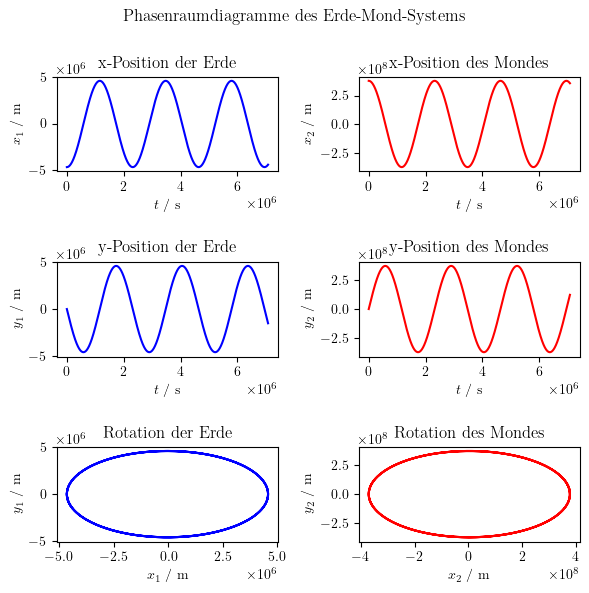

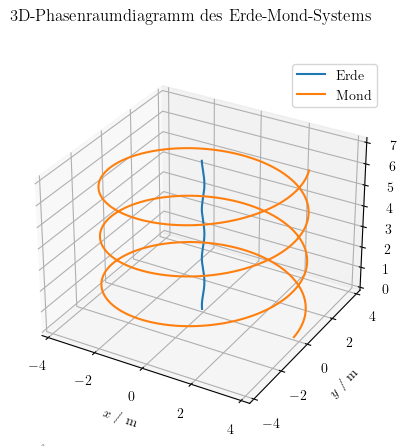

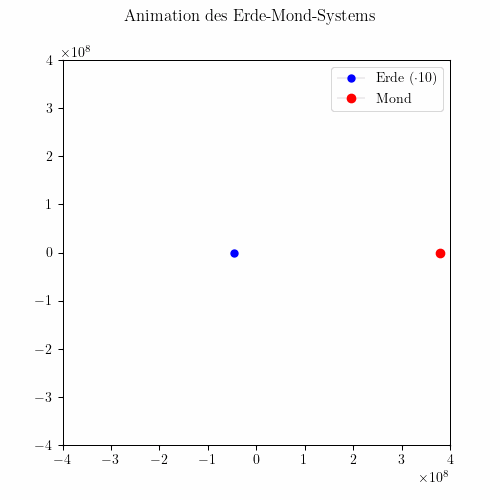

In [15]:
%matplotlib inline
# Plot the solution of the two body problem as a phase space diagram
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 6)) # Create a figure and a set of subplots
fig.suptitle("Phasenraumdiagramme des Erde-Mond-Systems")

def init_phase_space(ax, a, b, title, xlabel, ylabel, color):
    ax.plot(a, b, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

init_phase_space(axes[0,0], t, x_1, "x-Position der Erde", "$t$ / s", "$x_1$ / m", "blue")
init_phase_space(axes[0,1], t, x_2, "x-Position des Mondes", "$t$ / s", "$x_2$ / m", "red")
init_phase_space(axes[1,0], t, y_1, "y-Position der Erde", "$t$ / s", "$y_1$ / m", "blue")
init_phase_space(axes[1,1], t, y_2, "y-Position des Mondes", "$t$ / s", "$y_2$ / m", "red")
init_phase_space(axes[2,0], x_1, y_1, "Rotation der Erde", "$x_1$ / m", "$y_1$ / m", "blue")
init_phase_space(axes[2,1], x_2, y_2, "Rotation des Mondes", "$x_2$ / m", "$y_2$ / m", "red")
plt.tight_layout() # Adjust the spacing between subplots
plt.show()
plt.close()

# Plot a 3d phase space diagram
fig = plt.figure()
fig.suptitle("3D-Phasenraumdiagramm des Erde-Mond-Systems")
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_1, y_1, t, label="Erde")
ax.plot(x_2, y_2, t, label="Mond")
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()
plt.show()
plt.close()

# Animation of the two body problem
if not fastExecution: # Don't render if not necessary
    fig = plt.figure(figsize=(5, 5)) # Square figure, so the circles are actually circles
    fig.suptitle("Animation des Erde-Mond-Systems")
    ax = plt.axes(xlim=(-4e8, 4e8), ylim=(-4e8, 4e8))
    earth_line, = ax.plot([], [], marker='o', lw=0.1, color='blue', label="Erde ($\cdot 10$)")
    moon_line, = ax.plot([], [], marker='o', lw=0.1, color='red', label="Mond")
    ax.legend()

    def animate(i):
        earth_line.set_data([x_1[i]*10], [y_1[i]*10])
        moon_line.set_data([x_2[i]], [y_2[i]])
        return earth_line, moon_line

    anim = FuncAnimation(fig, animate, init_func=None, frames=t.shape[0], interval=30, blit=True)
    anim.save('Erde_Mond.gif', writer='pillow')
    plt.close()

display(Image(data=open('Erde_Mond.gif','rb').read(), format='png'))

#### Überprüfung

Nachem wir uns unsere Lösungen nun grafisch angeschaut haben, wollen wir diese noch auf ihre Korrektheit überprüfen.
Wir betrachten dazu das Baryzentrum. Dabei untersuchen wir was für einen Fehler die numerische Lösung bringt, indem wir verschiedene Verfahren vergleichen.

##### Baryzentrum

Zur Überprüfung unserer Ergebnisse und Anfangsbedingungen betrachten wir die Bewegung des Schwerpunktes. $\newline$
Der Schwerpunkt sollte sich in einem abgeschlossenen System, mit den von uns gewählten Anfangsbedingungen, nicht bewegen.
Gegen die Zeit aufgetragen, sollten seine x-, und y-Komponente also eine Konstante bei Null (wegen der Anfangsbedingungen, Schwerpunkt im Ursprung) sein.
Wie im Plot jedoch zu sehen ist, ist dies bei unseren Berechnungen nicht der Fall.
Die hier bestimmten Werte liegen aber im Bereich von $10^{-5}$ Metern, sind also um mehrere Größenordnungen kleiner als unsere betrachteten Abstände zwischen Erde und Mond.
Diese Fehler entstehen hier durch die numerische Berechnung des Problems.
Sie entstehen hier entweder durch das numerische Lösen der DGL oder durch die
Ungenauigkeit des float-Datentypen und der angegebenen Anfangswerte.

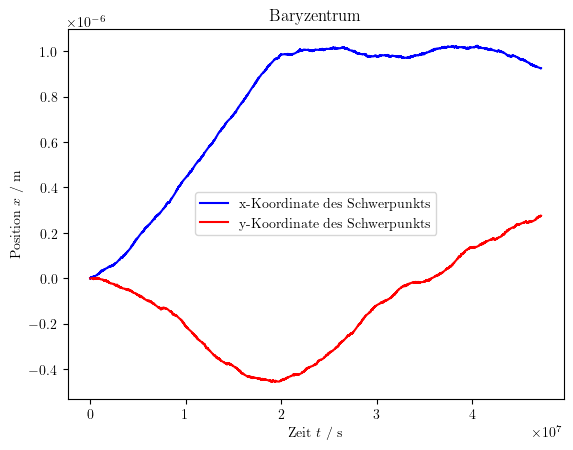

In [17]:
solution = two_body_problem(*iv_stable_orbit_2body(), (1 if fastExecution else 20)*TMondBahn)
t, x_1, y_1, x_2, y_2 = solution

def center_of_mass(m1, m2, x_1, y_1, x_2, y_2):
    '''Calculates the location of the center of mass of two bodies with masses m1 and m2 at positions (x1, y_1) and (x2, y_2)'''
    x_cm = (m1*x_1 + m2*x_2) / (m1 + m2)
    y_cm = (m1*y_1 + m2*y_2) / (m1 + m2)
    return x_cm, y_cm

%matplotlib inline
# Plot the change of the center of mass over time
fig, ax = plt.subplots()
fig.set_label("Bewegung des Baryzentrum des Erde-Mond-Systems")
ax.plot(t, center_of_mass(mErde, mMond, x_1, y_1, x_2, y_2)[0], color='blue', label='x-Koordinate des Schwerpunkts')
ax.plot(t, center_of_mass(mErde, mMond, x_1, y_1, x_2, y_2)[1], color='red', label='y-Koordinate des Schwerpunkts')
ax.set_xlabel('Zeit $t$ / s')
ax.set_ylabel('Position $x$ / m')
ax.set_title('Baryzentrum')
ax.legend()
plt.show()
plt.close()

##### Vergleich von explizitem Euler-Verfahren, Runge-Kutta-Verfahren 4. Ordnung und Runge-Kutta-Verfahren 45 (Standard in `solve_ivp()`)

Zwischen der Lösung mit dem expliziten Euler-Verfahren und der Lösung mit dem Runge-Kutta-Verfahren 4. Ordnung ist ein deutlicher Unterschied zu erkennen.
Es ist deutlich zu sehen, dass der Orbit des Mondes mit jedem Umlauf größer wird. Hier wird also eindeutig ein größerer numerischer Fehler gemacht.
Beim RK4 und RK45 ist derartiges nicht zu erkennen. Sie sind voneinander nicht zu unterscheiden.
Dies ist auch zu erwarten, da RK45 eine Weiterentwicklung von RK4 ist und nur bei sehr großen Schrittweiten Unterschiede zu erkennen sind.
Das Euler-Verfahren ist also in der Tat schlechter als das RK4-Verfahren, dafür aber auch deutlich weniger aufwendig. Diese kleine Genauigkeitseinbuße ist aber zu verschmerzen.

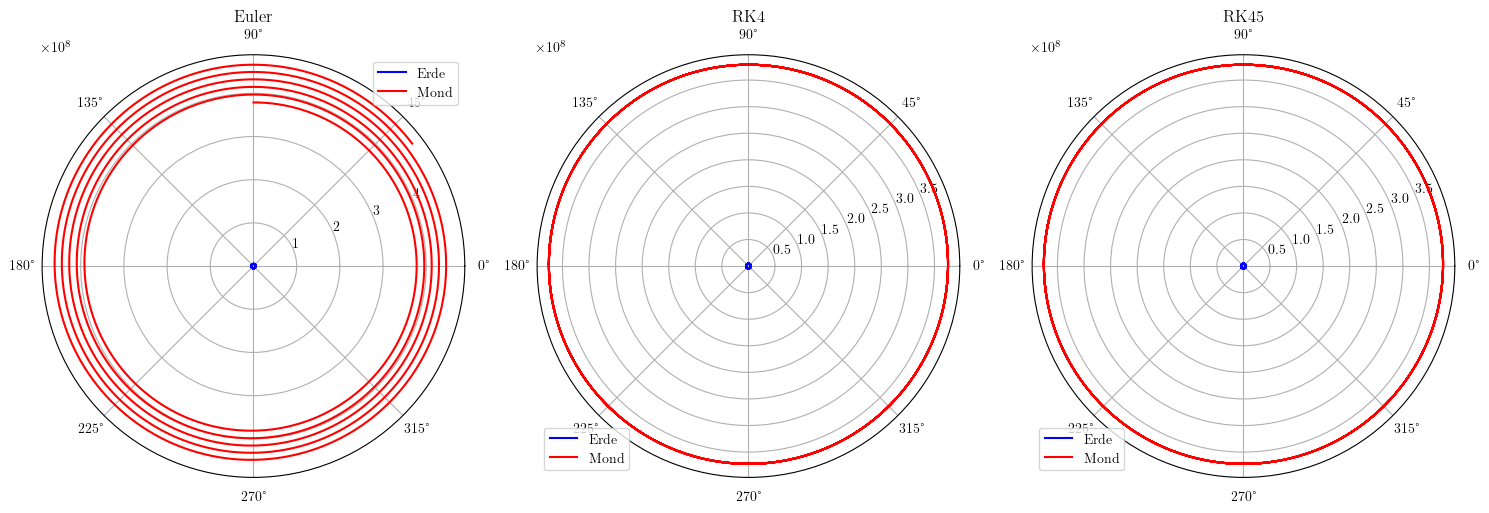

In [16]:
%matplotlib inline
revolutions = (1 if fastExecution else 6)
solution_euler = two_body_problem(*iv_stable_orbit_2body(), revolutions*TMondBahn, 10000, method="euler")
solution_rk4 = two_body_problem(*iv_stable_orbit_2body(), revolutions*TMondBahn, 10000, method="RK4")
solution_rk45 = two_body_problem(*iv_stable_orbit_2body(), revolutions*TMondBahn, 10000, method="RK45")

# To plot the solution in polar coordinates we need to convert the cartesian coordinates to polar coordinates
r = lambda x, y: np.sqrt(x**2 + y**2)
theta = lambda x, y: np.arctan2(x, y)

# Create a figure and a set of subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows= 1, ncols=3, figsize=(15, 15), subplot_kw={'projection': 'polar'})

def init_ploar(ax, t, x_1, y_1, x_2, y_2, title, color_1, color_2, label_1, label_2):
    ax.plot(theta(x_1, y_1), r(x_1, y_1), color=color_1, label=label_1)
    ax.plot(theta(x_2, y_2), r(x_2, y_2), color=color_2, label=label_2)
    ax.set_title(title)
    ax.legend()

init_ploar(ax1, *solution_euler, "Euler", "blue", "red", "Erde", "Mond")
init_ploar(ax2, *solution_rk4, "RK4", "blue", "red", "Erde", "Mond")
init_ploar(ax3, *solution_rk45, "RK45", "blue", "red", "Erde", "Mond")
plt.tight_layout()
plt.show()
plt.close()

### Vierkörperproblem mit Randbedingungen

Wir erweitern nun das Zweikörperproblem um die beiden Flutberge, die sich auf der Erdoberfläche befinden.
Dazu werden die beiden Flutberge als Punktmassen genähert, deren Abstand zur Erde zu jeder Zeit dem Erdradius entspricht.
Die gegenseitige Gravitationskraft der beiden Flutberge ist sehr gering und wird daher im Folgenden vernachlässigt, d.h. $\vec F_{21}$=$\vec F_{12}=0$. 

Die radiale Kraftkomponente der Flutberge muss den Abstand zur Erde konstant halten (Erdradius). Dazu werden radiale Zwangskräfte eingeführt, die die ebenfalls radiale Gravitationskraft der Erde beinhalten. $\vec F_{\mathrm{Z}i}$ ist also Summe von Zwangskraft und Gravitationskraft der Erde auf Flutberg $i$, sie wirkt entgegengestzt auch auf die Erde.

Damit ergibt sich für die Gesamtkräfte $\vec F_\mathrm{E}$, $\vec F_\mathrm{M}$, $\vec F_1$, $\vec F_2$ auf Erde, Mond, Flutberg 1 bzw. Flutberg 2 folgendes Gleichungssystem:
    
$\newline$
\begin{align*}
    \vec F_\mathrm{E} &= \vec F_\mathrm{ME} - \vec F_{\mathrm{Z}1} - \vec F_{\mathrm{Z}2} \\
    \vec F_\mathrm{M} &= \vec F_\mathrm{EM} + \vec F_{1\mathrm{M}} + \vec F_{2\mathrm{M}} \\
    \vec F_1 &=  \vec F_{\mathrm{M}1} + \vec F_{\mathrm{Z}1} \\
    \vec F_2 &= \vec F_{\mathrm{M}2} + \vec F_{\mathrm{Z}2}      
\end{align*}

Die Koordinaten des $i$-ten Flutbergs lassen sich am elegantesten in Polarkoordinaten relativ zu den Erdkoordinaten $\vec r_\mathrm{E}$ angeben: $\vec r_i = \vec r_\mathrm{E} + R_\mathrm{E}\,\vec e_{r,i}\, $.
Hierfür werden $\varphi_i$ der Winkel des $i$-ten Flutbergs relativ zur Erde, $m_i$ die Masse, $\vec e_{r,i}$, der radiale Einheitsvektor und $\vec e_{\varphi,i}$ der Einheitsvektor in $\varphi_i$-Richtung in Bezug auf den $i$-ten Flutberg, verwendet.

Die Kraft auf den $i$-ten Flutberg lässt sich nun in einen radialen Anteil und einen Winkelanteil aufteilen:
$\newline$
\begin{align*}
    \vec F_i &= (\vec F_{\mathrm{M}i})_{\varphi,i} \vec e_{\varphi,i} + (\vec F_{\mathrm{M}i})_{r,i} \vec e_{r,i} + F_{\mathrm{Z}i} \vec e_{r,i} \\
    &= (\vec F_{\mathrm{M}i})_{\varphi,i} \vec e_{\varphi,i} + ((\vec F_{\mathrm{M}i})_{r,i} + F_{\mathrm{Z}i})\, \vec e_{r,i}\,. 
\end{align*}

Die Beschleunigung des $i$-ten Flutberg in Richtung Erde muss der Zentripetalbeschleunigung für stabile Kreisbahnen abzüglich der Beschleunigung der Erde in radiale Richtung betragen, damit die Zwangsbedingung (ZB) erfüllt ist, d.h.
$\newline$
\begin{equation*}
    (\vec F_{\mathrm{M}i})_{r,i} + F_{\mathrm{Z}i} \stackrel{\mathrm{ZB}}{=} -m_i \left( R_\mathrm{E} \dot{\varphi}_i^2 - (\ddot{\vec r_\mathrm{E}})_{r,i} \right)\,,
\end{equation*}

Die so aufgestellten Differentialgleichungen sind noch gekoppelt, sie müssen also noch nach den einzelnen Beschleunigungen aufgelöst werden um an `solve_ivp()` übergeben werden zu können.
Im Folgenden werden die Gleichungen hergeleitet. $\newline$

Für die Flutberge werden Polarkoordinaten verwendet, es gilt also:
$\newline$
\begin{align*}
    x_i = x_\mathrm{E} + R_\mathrm{E}\cos{\varphi_i}\\
    y_i = y_\mathrm{E} + R_\mathrm{E}\sin{\varphi_i}
\end{align*}

Stellt man die Zwangsbedingung nach der Zwangskraft um und setzt in die Kraft auf die Erde ein, so erhält man:
$\newline$
\begin{align*}
    \vec F_\mathrm{E} &= \vec F_\mathrm{ME} + (m_1 \left( R_\mathrm{E} \dot{\varphi}_1^2 - (\ddot{\vec r_\mathrm{E}})_{r,1} \right)\, + (\vec F_{\mathrm{M}1})_{r,1})\vec e_{r,1} + (m_2 \left( R_\mathrm{E} \dot{\varphi}_i^2 - (\ddot{\vec r_\mathrm{E}})_{r,2} \right)\, + (\vec F_{\mathrm{M}i})_{r,2})\vec e_{r,2} \\      
\end{align*}

Die r-Komponente erhält man durch projektion mit dem entsprechenden Einheitsvektor $\vec e_{r,i}$, und es ergibt sich mit umstellen der Gleichung:
$\newline$
\begin{align*}
    \ddot{x}_\mathrm{E} = \frac{1}{\mu_x} (a(x_\mathrm{M} - x_\mathrm{E}) - b\ddot{y_\mathrm{E}} + c_1\cos{\varphi_1} + c_2\cos{\varphi_2})\\
    \ddot{y}_\mathrm{E} = \frac{1}{\mu_y} (a(y_\mathrm{M} - y_\mathrm{E}) - b\ddot{x_\mathrm{E}} + c_1\sin{\varphi_1} + c_2\sin{\varphi_2})
\end{align*}

Mit den Abkürzungen:
$\newline$
\begin{align*}
    \mu_x &= m_\mathrm{E} + m_1\cos{\varphi_1}^2 + m_2\cos{\varphi_2}^2\\
    \mu_y &= m_\mathrm{E} + m_1\sin{\varphi_1}^2 + m_2\sin{\varphi_2}^2\\
    a &= \frac{Gm_\mathrm{M}m_\mathrm{E}}{((x_\mathrm{M} - x_\mathrm{E})^2 + (y_\mathrm{M} - y_\mathrm{E})^2)^{\frac{3}{2}}}\\
    b &= m_1\sin{\varphi_1}\cos{\varphi_1} + m_2\sin{\varphi_2}\cos{\varphi_2}\\
    c_i &= m_iR_\mathrm{E}\dot{\varphi}_i^2 + \frac{Gm_\mathrm{M}m_i((x_\mathrm{M} - x_i)\cos{\varphi_i} + (y_\mathrm{M} - y_i)\sin{\varphi_i})}{((x_\mathrm{M} - x_i)^2 + (y_\mathrm{M} - y_i)^2)^{\frac{3}{2}}}
\end{align*}

Um diese Differentialgleichungen an `solve_ivp()` zu übergeben müssen sie noch entkoppelt werden.
Hierzu setzen wir $\ddot{y}_\mathrm{E}$ in die Gleichung für $\ddot{x}_\mathrm{E}$ ein, und stellen nach $\ddot{x}_\mathrm{E}$ um ($\ddot{y}_\mathrm{E}$ erhalten wir dann durch einsetzen vom berechneten $\ddot{x}_\mathrm{E}$):
$\newline$
\begin{align*}
    \ddot{x}_\mathrm{E} = \frac{a(x_\mathrm{M} - x_\mathrm{E}) - \frac{b}{\mu_y}(a(y_\mathrm{M} - y_\mathrm{E}) + c_1\sin{\varphi_1} + c_2\sin{\varphi_2}) + c_1\cos{\varphi_1} + c_2\cos{\varphi_2}}{\mu_x - \frac{b^2}{\mu_y}}
\end{align*}

Die Kraft auf den Mond lässt sich mit der Gravitationskraft einfach durch einsetzen bestimmen, was zu folgenden Gleichungen führt:
$\newline$
\begin{align*}
    \ddot{x}_\mathrm{M} =   G \left( \frac{m_\mathrm{E}(x_\mathrm{E} - x_\mathrm{M})}{((x_\mathrm{E} - x_\mathrm{M})^2 + (y_\mathrm{E} - y_\mathrm{M})^2)^{\frac{3}{2}}}
                            + \frac{m_1(x_1 - x_\mathrm{M})}{((x_1 - x_\mathrm{M})^2 + (y_1 - y_\mathrm{M})^2)^{\frac{3}{2}}}
                            + \frac{m_2(x_2 - x_\mathrm{M})}{((x_2 - x_\mathrm{M})^2 + (y_2 - y_\mathrm{M})^2)^{\frac{3}{2}}} \right)\\
    \ddot{y}_\mathrm{M} =   G \left( \frac{m_\mathrm{E}(y_\mathrm{E} - y_\mathrm{M})}{((x_\mathrm{E} - x_\mathrm{M})^2 + (y_\mathrm{E} - y_\mathrm{M})^2)^{\frac{3}{2}}}
                            + \frac{m_1(y_1 - y_\mathrm{M})}{((x_1 - x_\mathrm{M})^2 + (y_1 - y_\mathrm{M})^2)^{\frac{3}{2}}}
                            + \frac{m_2(y_2 - y_\mathrm{M})}{((x_2 - x_\mathrm{M})^2 + (y_2 - y_\mathrm{M})^2)^{\frac{3}{2}}} \right)\\
\end{align*}

Für die Kraft auf die Flutberge kann die Zwangskraft in der Form, in der sie angegeben ist eingesetzt werden:
$\newline$
\begin{align*}
    \vec F_i = (\vec F_{\mathrm{M}i})_{\varphi,i} \vec e_{\varphi,i} -(m_i \left( R_\mathrm{E} \dot{\varphi}_i^2 - (\ddot{\vec r_\mathrm{E}})_{r,i} \right)\,)\, \vec e_{r,i}\,. \\
\end{align*}

Die r- bzw. $\varphi$-Komponente erhält man wieder mit den entsprechenden Einheitsvektoren, und wir erhalten:
$\newline$
\begin{align*}
    \ddot{x}_i =   -\frac{Gm_\mathrm{M}((y_\mathrm{M} - y_i)\cos{\varphi_i} - (x_\mathrm{M} - x_i)\sin{\varphi_i})}{((x_\mathrm{M} - x_i)^2 + (y_\mathrm{M} - y_i)^2)^{\frac{3}{2}}}\sin{\varphi_i}
                    - (R_\mathrm{E}\dot{\varphi_i}^2 - (\ddot{x}_\mathrm{E}\cos{\varphi_i} + \ddot{y}_\mathrm{E}\sin{\varphi_i}))\cos{\varphi_i}\\
    \ddot{y}_i =   \frac{Gm_\mathrm{M}((y_\mathrm{M} - y_i)\cos{\varphi_i} - (x_\mathrm{M} - x_i)\sin{\varphi_i})}{((x_\mathrm{M} - x_i)^2 + (y_\mathrm{M} - y_i)^2)^{\frac{3}{2}}}\cos{\varphi_i}
                    - (R_\mathrm{E}\dot{\varphi_i}^2 - (\ddot{x}_\mathrm{E}\cos{\varphi_i} + \ddot{y}_\mathrm{E}\sin{\varphi_i}))\sin{\varphi_i}
\end{align*}

Wir brauchen aber $\ddot{\varphi_i}$, dazu leiten wir die Koordinaten der Flutberge zwei mal nach der Zeit ab:
$\newline$
\begin{align*}
    \ddot{\vec r_i} = \ddot{\vec r_\mathrm{E}} + R_\mathrm{E}(\ddot{\varphi_i}\vec e_{\varphi,i}\, - \dot{\varphi_i}^2\vec e_{r,i}\,)\\
    \ddot{\varphi_i}\vec e_{\varphi,i}\, = \frac{\ddot{\vec r_i} - \ddot{\vec r_\mathrm{E}}}{R_\mathrm{E}} + \dot{\varphi_i}^2\vec e_{r,i}\,
\end{align*}

Durch multiplikation mit $\vec e_{\varphi,i}\,$ erhält man:
$\newline$
\begin{align*}
    \ddot{\varphi_i} = \frac{-(\ddot{x}_i - \ddot{x}_\mathrm{E})\sin{\varphi_i} + (\ddot{y}_i - \ddot{y}_\mathrm{E})\cos{\varphi_i}}{R_\mathrm{E}}
\end{align*}

#### Lösen mit SymPy
Für das lösen/entkoppeln der Differentialgleichungen kann alternativ zur Berechnung per Hand, wie oben durchgeführt, SymPy verwendet werden.

Hierzu werden zunächst die oben aufgestellten Differentialgleichungen in Pythoncode geschrieben.
Bei der Defintion können wir SymPy die verschieden Ableitungen, Skalarprodukte und anderen per Hand sehr zeitaufwendigen Schritte direkt berechnen lassen.
Danach fassen wir für die Erde noch Teile der Gleichung zur Variablen zusammen, um `linsolve()` die Arbeit zu erleichtern.
Dieser Schritt ist sehr wichtig, da er die Rechenzeit um mehr als einen Faktor 100 reduziert!

Nachdem wir die Differentialgleichungen entkoppelt haben und aufgelöst haben, werden sie mit `lambdify()` in numerische Funktionen umgewandelt.
Der Umwandlungsprozess ist ebenfalls sehr zeitaufwendig und beträgt mehr als die Hälfte der Gesamtlaufzeit.
Er ist aber notwendig, um die Berechnung mit `solve_ivp()` durchführen zu können.

Die hier mit SymPy berechneten Funktionen sind leider sehr lang und kompliziert; das vereinfachen mit `simplify()` dauert leider sehr sehr lange und lohnt sich hier nicht,
da die unten per Hand definierten Funktionen sowieso schneller sind als alles was SymPy erreichen könnte.

In [11]:
t = sympy.symbols('t', real=True, positive=True) # Time variable for all functions
x_E, y_E, x_M, y_M, phi_1, phi_2 = [f(t) for f in sympy.symbols('x_E, y_E, x_M, y_M, phi_1, phi_2', real=True, cls=sympy.Function)] # The variables are functions of time

# Variables for the  masses and distances between the bodies
mErdeS, mMondS, m1S, m2S = sympy.symbols('m_Erde, m_Mond, m_1, m_2', real=True, positive=True)
dist_em, dist_m1, dist_m2 = sympy.symbols('d_em, d_m1, d_m2', real=True, positive=True)

# Coordinate vectors of the tides
r_1 = sympy.Matrix([x_E + RErde*sympy.cos(phi_1), y_E + RErde*sympy.sin(phi_1)])
r_2 = sympy.Matrix([x_E + RErde*sympy.cos(phi_2), y_E + RErde*sympy.sin(phi_2)])

# Force vectors
F_ME = -G*mErde*mMondS / (dist_em**3) * sympy.Matrix([x_E-x_M, y_E-y_M]) 
F_1M = -G*mMond*m1S    / (dist_m1**3) * (sympy.Matrix([x_M, y_M]) - r_1)
F_2M = -G*mMond*m2S    / (dist_m2**3) * (sympy.Matrix([x_M, y_M]) - r_2)

# Polar unit vectors for phi_1 and phi_2
e_r_1, e_phi_1 = sympy.Matrix([sympy.cos(phi_1), sympy.sin(phi_1)]), sympy.Matrix([-sympy.sin(phi_1), sympy.cos(phi_1)])
e_r_2, e_phi_2 = sympy.Matrix([sympy.cos(phi_2), sympy.sin(phi_2)]), sympy.Matrix([-sympy.sin(phi_2), sympy.cos(phi_2)])

# The radial component of the earth's acceleration vector
a_E_r = sympy.Matrix([x_E.diff(t, t), y_E.diff(t, t)])

# Constraint force vectors on the tides
F_Z1 = (F_1M.dot(e_r_1) + m1S*(RErde*(phi_1.diff(t))**2 - a_E_r.dot(e_r_1))) * e_r_1
F_Z2 = (F_2M.dot(e_r_2) + m2S*(RErde*(phi_2.diff(t))**2 - a_E_r.dot(e_r_2))) * e_r_2

# Forces on the tides
F_1 = (-F_1M).dot(e_phi_1) * e_phi_1 - (m1S* (RErde*phi_1.diff(t)**2 - a_E_r.dot(e_r_1))) * e_r_1
F_2 = (-F_2M).dot(e_phi_2) * e_phi_2 - (m2S* (RErde*phi_2.diff(t)**2 - a_E_r.dot(e_r_2))) * e_r_2

# We now write the equations of motion
eq1 = sympy.Eq(mErdeS * x_E.diff(t, t), (F_ME[0] + F_Z1[0] + F_Z2[0]))
eq2 = sympy.Eq(mErdeS * y_E.diff(t, t), (F_ME[1] + F_Z1[1] + F_Z2[1]))
eq3 = sympy.Eq(mMondS * x_M.diff(t, t), (-F_ME[0] + F_1M[0] + F_2M[0]))
eq4 = sympy.Eq(mMondS * y_M.diff(t, t), (-F_ME[1] + F_1M[1] + F_2M[1]))
eq5 = sympy.Eq(m1S*(r_1[0]).diff(t, t), F_1[0])
eq6 = sympy.Eq(m1S*(r_1[1]).diff(t, t), F_1[1])
eq7 = sympy.Eq(m2S*(r_2[0]).diff(t, t), F_2[0])
eq8 = sympy.Eq(m2S*(r_2[1]).diff(t, t), F_2[1])

# From here on we replace the variables with symbols and actually solve the equations
# Replace the functions and their derivatives with symbols
function_variables = [x_E, y_E, x_M, y_M, phi_1, phi_2, x_E.diff(t), y_E.diff(t), x_M.diff(t), y_M.diff(t), phi_1.diff(t), phi_2.diff(t), x_E.diff(t, t), y_E.diff(t, t), x_M.diff(t, t), y_M.diff(t, t), phi_1.diff(t, t), phi_2.diff(t, t)]
variables = sympy.symbols('x_E, y_E, x_M, y_M, phi_1, phi_2 \dot{x_E}, \dot{y}_E, \dot{x}_M, \dot{y}_M, \dot{\phi}_1, \dot{\phi}_2 \ddot{x}_E, \ddot{y}_E, \ddot{x}_M, \ddot{y}_M, \ddot{\phi}_1, \ddot{\phi}_2', real=True)
variable_replacements = {key: value for key, value in zip(function_variables, variables)}
equations_var = [eq.subs(variable_replacements) for eq in [eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8]] # Replace the variables in the differential equations
x_E, y_E, x_M, y_M, phi_1, phi_2, x_E_dot, y_E_dot, x_M_dot, y_M_dot, phi_1_dot, phi_2_dot, x_E_ddot, y_E_ddot, x_M_ddot, y_M_ddot, phi_1_ddot, phi_2_ddot = variables # Redefine the variables
    
# Distances as equations for replacing the constants
dist_em_eq = sympy.sqrt((x_E-x_M)**2+(y_E-y_M)**2)
dist_m1_eq = sympy.sqrt((x_M-x_E-RErde*sympy.cos(phi_1))**2+(y_M-y_E-RErde*sympy.sin(phi_1))**2)
dist_m2_eq = sympy.sqrt((x_M-x_E-RErde*sympy.cos(phi_2))**2+(y_M-y_E-RErde*sympy.sin(phi_2))**2)

# Solving the equations for the moon
moon_acc = sympy.linsolve(equations_var[2:4], variables[14:16])
moon_acc = [eq.subs({dist_em: dist_em_eq, dist_m1: dist_m1_eq, dist_m2: dist_m2_eq}) for eq in moon_acc.args[0]]

# Solving the equations for the earth
# Replace parts of the equations with symbols. These are similar but not exactly the same as the symbols in the description/calculation above
mu_xs, mu_ys, part_a, part_b, c11, c13, c21, c23, c31, c33, c41, c43 = sympy.symbols('mu_xs, mu_ys, a, b, c_11, c13, c_21, c_23, c_31, c_33, c_41, c_43', real=True)

earth_x_rhs = (equations_var[0].rhs)
mu_x_eq = earth_x_rhs.expand().collect(x_E_ddot).coeff(x_E_ddot)
earth_x_rhs = earth_x_rhs.expand().collect(x_E_ddot).subs({mu_x_eq: mu_xs})
b_eq = earth_x_rhs.expand().collect(y_E_ddot).coeff(y_E_ddot)
earth_x_rhs = earth_x_rhs.expand().collect(y_E_ddot).subs({b_eq: part_b})
a_eq = earth_x_rhs.expand().collect(x_M).collect(x_E).coeff(x_M) 
earth_x_rhs = earth_x_rhs.expand().collect(x_M).collect(x_E).subs({a_eq: part_a})
exprCos = earth_x_rhs.expand().collect(sympy.cos(phi_1)).collect(sympy.cos(phi_2))
c11_eq = exprCos.coeff(sympy.cos(phi_1))
c21_eq = exprCos.coeff(sympy.cos(phi_2))
c13_eq = exprCos.coeff(sympy.cos(phi_1)**3)*sympy.cos(phi_1)**2
c23_eq = exprCos.coeff(sympy.cos(phi_2)**3)*sympy.cos(phi_2)**2
earth_x_rhs = earth_x_rhs.expand().collect(sympy.cos(phi_1)).collect(sympy.cos(phi_2)).subs({c11_eq: c11, c21_eq: c21, c13_eq: c13, c23_eq: c23})

earth_y_rhs = (equations_var[1].rhs)
mu_y_eq = earth_y_rhs.expand().collect(y_E_ddot).coeff(y_E_ddot)
earth_y_rhs = earth_y_rhs.expand().collect(y_E_ddot).subs({mu_y_eq: mu_ys})
b_eq = earth_y_rhs.expand().collect(x_E_ddot).coeff(x_E_ddot)
earth_y_rhs = earth_y_rhs.expand().collect(x_E_ddot).subs({b_eq: part_b})
a_eq = earth_y_rhs.expand().collect(y_M).collect(y_E).coeff(y_M)
earth_y_rhs = earth_y_rhs.expand().collect(y_M).collect(y_E).subs({a_eq: part_a})
exprSin = earth_y_rhs.expand().collect(sympy.sin(phi_1)).collect(sympy.sin(phi_2))
c31_eq = exprSin.coeff(sympy.sin(phi_1))
c41_eq = exprSin.coeff(sympy.sin(phi_2))
c33_eq = exprSin.coeff(sympy.sin(phi_1)**3)*sympy.sin(phi_1)**2
c43_eq = exprSin.coeff(sympy.sin(phi_2)**3)*sympy.sin(phi_2)**2
earth_y_rhs = earth_y_rhs.expand().collect(sympy.sin(phi_1)).collect(sympy.sin(phi_2)).subs({c31_eq: c31, c41_eq: c41, c33_eq: c33, c43_eq: c43})

# Rewrite the equations with the substituted symbols and solve
simplified_earth_x = sympy.Eq(equations_var[0].lhs, earth_x_rhs)
simplified_earth_y = sympy.Eq(equations_var[1].lhs, earth_y_rhs)
earth_acc = sympy.linsolve([simplified_earth_x, simplified_earth_y], [x_E_ddot, y_E_ddot])
earth_acc = [eq.subs({mu_xs: mu_x_eq, mu_ys: mu_y_eq, part_a: a_eq, part_b: b_eq, c11: c11_eq, c13: c13_eq, c21: c21_eq, c23: c23_eq, c31: c31_eq, c33: c33_eq, c41: c41_eq, c43: c43_eq}).subs({dist_em: dist_em_eq, dist_m1: dist_m1_eq, dist_m2: dist_m2_eq}) for eq in earth_acc.args[0]]

# Solve the equations for the tides
phi_1_acc = ((-(equations_var[4].rhs/m1S - earth_acc[0])*sympy.sin(phi_1) + (equations_var[5].rhs/m1S - earth_acc[1])*sympy.cos(phi_1))/(RErde)).subs({dist_em: dist_em_eq, dist_m1: dist_m1_eq, dist_m2: dist_m2_eq}).subs({x_E_ddot: earth_acc[0], y_E_ddot: earth_acc[1]})
phi_2_acc = ((-(equations_var[6].rhs/m2S - earth_acc[0])*sympy.sin(phi_2) + (equations_var[7].rhs/m2S - earth_acc[1])*sympy.cos(phi_2))/(RErde)).subs({dist_em: dist_em_eq, dist_m1: dist_m1_eq, dist_m2: dist_m2_eq}).subs({x_E_ddot: earth_acc[0], y_E_ddot: earth_acc[1]})

# Lambdify the equations for the numerical integration
lambdified_accelerations = [sympy.lambdify([*variables[0:12], (mErdeS, mMondS, m1S, m2S)], acc, modules='numpy') for acc in earth_acc + moon_acc + [phi_1_acc, phi_2_acc]]

def eq_motion_4body_sympy(t, state, mass):
    '''This function calculates the derivatives of the state vector for a specific 4 body problem (Earth-Moon with tidal forces) to be passed to solve_ivp. \\
    state: state vector is given by [x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2].
    mass: list of the masses of the two bodys. e.g. [m_E, m_M, m1, m2]'''
    x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2 = state
    ax_E = lambdified_accelerations[0](*state, mass)
    ay_E = lambdified_accelerations[1](*state, mass)
    ax_M = lambdified_accelerations[2](*state, mass)
    ay_M = lambdified_accelerations[3](*state, mass)
    alpha_1 = lambdified_accelerations[4](*state, mass)
    alpha_2 = lambdified_accelerations[5](*state, mass)
    return [vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2, ax_E, ay_E, ax_M, ay_M, alpha_1, alpha_2]

#### Gleichungen per Hand

Wie oben bereits gesagt, ist es sinnvoler die Gleichungen per Hand zu lösen, da `sympy` die Gleichungen nicht in "normaler" Zeit vereinfachen kann,
das heißt, dass man ein wenig Rechenzeit sparen kann, wenn man es per Hand macht.
Dieses "nicht vereinfachen" der Gleichungen führt zu einer Verlängerung der Laufzeit um ungefähr 730%,
diese nicht vereinfachten Gleichungen führen auch zu mehr numerischen Fehlern.

In [12]:
def tide_acceleration(x_M, y_M, x_i, y_i, phi_i, ax_E, ay_E, omega_i, m_M):
    '''Calculates the angular acceleration of a tide, using the equation above'''
    part_a = G*m_M* ((y_M - y_i)*np.cos(phi_i) - (x_M - x_i)*np.sin(phi_i)) / ((x_M - x_i)**2 + (y_M - y_i)**2)**(3/2)
    part_b = (RErde*omega_i**2 - (ax_E*np.cos(phi_i) + ay_E*np.sin(phi_i)))
    ax_i = -part_a*np.sin(phi_i) - part_b*np.cos(phi_i)
    ay_i =  part_a*np.cos(phi_i) - part_b*np.sin(phi_i)

    alpha_i = (-(ax_i - ax_E)*np.sin(phi_i) + (ay_i - ay_E)*np.cos(phi_i))/RErde
    return alpha_i

def eq_motion_4body(t, state, mass):
    '''This function calculates the derivatives of the state vector for a specific 4 body problem (Earth-Moon with tidal forces) to be passed to solve_ivp. \\
    state: state vector is given by [x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2].
    mass: list of the masses of the two bodys. e.g. [m_E, m_M, m1, m2]'''
    x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2 = state
    m_E, m_M, m_1, m_2 = mass

    # Variables as defined in the explanation above
    x_1, y_1, x_2, y_2 = x_E + RErde*np.cos(phi_1), y_E + RErde*np.sin(phi_1), x_E + RErde*np.cos(phi_2), y_E + RErde*np.sin(phi_2)
    mu_x = m_E + m_1*np.cos(phi_1)**2 + m_2*np.cos(phi_2)**2
    mu_y = m_E + m_1*np.sin(phi_1)**2 + m_2*np.sin(phi_2)**2
    a = (G*m_M*m_E)/((x_M - x_E)**2 + (y_M - y_E)**2)**(3/2)
    b = m_1*np.sin(phi_1)*np.cos(phi_1) + m_2*np.sin(phi_2)*np.cos(phi_2)
    c1 = m_1*RErde*omega_1**2 + (G*m_M*m_1*((x_M - x_1)*np.cos(phi_1) + (y_M - y_1)*np.sin(phi_1)))/((x_M - x_1)**2 + (y_M - y_1)**2)**(3/2)
    c2 = m_2*RErde*omgea_2**2 + (G*m_M*m_2*((x_M - x_2)*np.cos(phi_2) + (y_M - y_2)*np.sin(phi_2)))/((x_M - x_2)**2 + (y_M - y_2)**2)**(3/2)

    # The earth's acceleration:    
    ax_E = 1/(mu_x - b**2/mu_y) * (a*(x_M - x_E) -b/mu_y*(a*(y_M - y_E) + c1*np.sin(phi_1) + c2*np.sin(phi_2)) + c1*np.cos(phi_1) + c2*np.cos(phi_2))
    ay_E = 1/mu_y*(a*(y_M - y_E) - b*ax_E + c1*np.sin(phi_1) + c2*np.sin(phi_2))

    # The moon's acceleration:
    ax_M = G*((m_E*(x_E - x_M))/((x_E - x_M)**2 + (y_E - y_M)**2)**(3/2) + (m_1*(x_1 - x_M))/((x_1 - x_M)**2 + (y_1 - y_M)**2)**(3/2) + (m_2*(x_2 - x_M))/((x_2 - x_M)**2 + (y_2 - y_M)**2)**(3/2))
    ay_M = G*((m_E*(y_E - y_M))/((x_E - x_M)**2 + (y_E - y_M)**2)**(3/2) + (m_1*(y_1 - y_M))/((x_1 - x_M)**2 + (y_1 - y_M)**2)**(3/2) + (m_2*(y_2 - y_M))/((x_2 - x_M)**2 + (y_2 - y_M)**2)**(3/2))

    # The tide's angular acceleration:
    alpha_1 = tide_acceleration(x_M, y_M, x_1, y_1, phi_1, ax_E, ay_E, omega_1, m_M)
    alpha_2 = tide_acceleration(x_M, y_M, x_2, y_2, phi_2, ax_E, ay_E, omgea_2, m_M)

    return[vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2, ax_E, ay_E, ax_M, ay_M, alpha_1, alpha_2]

Die Anfangsbedingungen müssen auf das erweiterte System angepasst werden.
Wir teilen die Masse des Ozeans gleichmäßig auf die beiden Flutberge auf und lassen die beiden Flutberge auf der Verbindungslinie zwischen Erde und Mond mit der Umlaufperiodendauer des Mondes starten. Wir berechnen den Schwerpunkt des Systems und legen ihn in den Ursprung.
Da die Flutberge auf gegenüberliegenden Seiten der Erde sind spielt ihr Abstand hier keine Rolle; ihre Masse könnte auch einfach zur Erde dazu addiert werden.

In [13]:
def center_of_mass(mass, position_x , position_y):
    '''Returns the coordinates of the center of mass of the system'''
    x = np.sum(mass*position_x)/np.sum(mass)
    y = np.sum(mass*position_y)/np.sum(mass)
    return [x, y]

def iv_stable_orbit_4body():
    '''Initial conditions for the Earth-Moon-Tides system in a stable orbit'''
    mass = [mErde, mMond, mOzean/2, mOzean/2] # Each of the tides gets half of the ocean's mass
    
    # We want the center of mass to be at the origin, the tides count towards the earth
    abstand_baryzentrum_erde = center_of_mass(mass, np.array([0, rMondBahn, -RErde, RErde]), np.array([0, 0, 0, 0]))[0]
    x0_Erde = [-abstand_baryzentrum_erde, 0]
    x0_Mond = [rMondBahn - abstand_baryzentrum_erde, 0]

    # We choose the starting velocities such that the center of mass is at rest
    vy0_Erde = 2*pi*abstand_baryzentrum_erde/TMondBahn
    vy0_Mond = 2*pi*(rMondBahn-abstand_baryzentrum_erde)/TMondBahn

    # The moon starts in positive, the earth in negative y-direction
    v0_Erde = [0, -vy0_Erde]
    v0_Mond = [0, vy0_Mond]

    # The tides start on the x-axis on opposite sides of the earth with the angular velocity of the moon
    phi_1, phi_2 = 0, pi
    omega_1, omega_2 = 2*pi/TMondBahn, 2*pi/TMondBahn 

    return [x0_Erde, x0_Mond, [phi_1, phi_2], v0_Erde, v0_Mond, [omega_1, omega_2], mass]

def four_body_problem(pos_body_1: list, pos_body_2: list, phi_i: list, vel_body_1: list, vel_body_2: list, omega_i: list, mass: list, t_max: float, fun=eq_motion_4body, steps=1, method='RK45', t_start=0):
    solution = solve_ivp(fun=fun, t_span=[t_start, t_max], y0=[*pos_body_1, *pos_body_2, *phi_i, *vel_body_1, *vel_body_2, *omega_i], args=(mass,), rtol=1e-12, atol=1e-12)
    x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omega_2 = solution.y
    return [solution.t, x_E, y_E, x_M, y_M, phi_1, phi_2]

#### Graphische Darstellung

Wir wollen die für sympy und per Hand berechneten Funktionen vergleichen, dazu plotten wir mehrere Phasenraumplots der beiden Simulationen.

In [14]:
# We execute the sympy and the direct solution to compare them
t, x_E, y_E, x_M, y_M, phi_1, phi_2 = four_body_problem(*iv_stable_orbit_4body(), 0.75*TMondBahn)

In [15]:
tS, x_ES, y_ES, x_MS, y_MS, phi_1S, phi_2S = four_body_problem(*iv_stable_orbit_4body(), 0.75*TMondBahn, fun=eq_motion_4body_sympy)

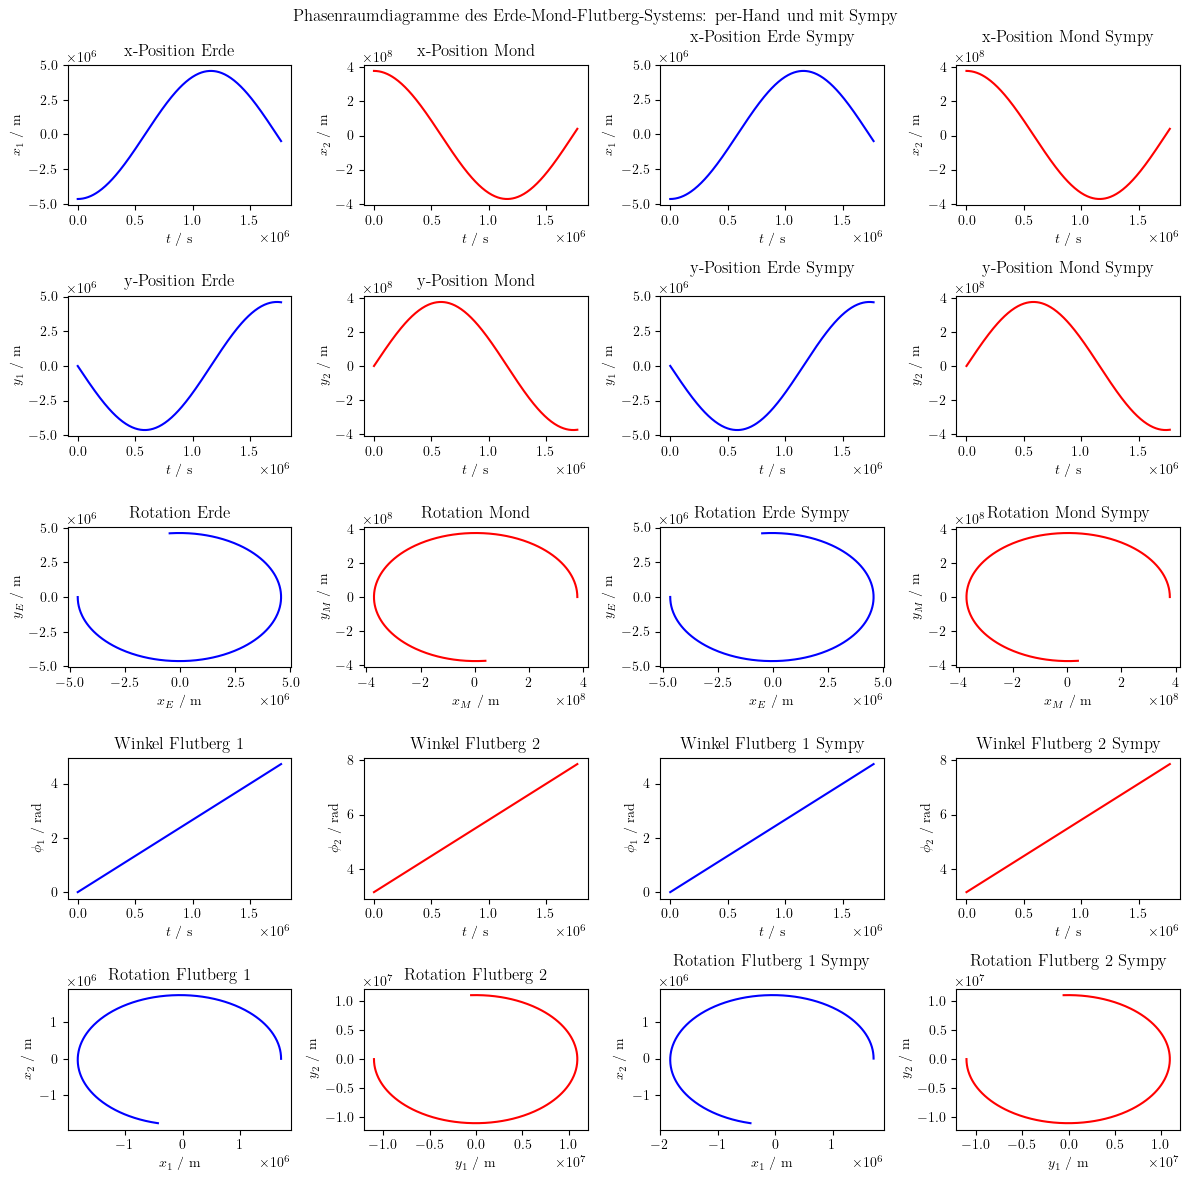

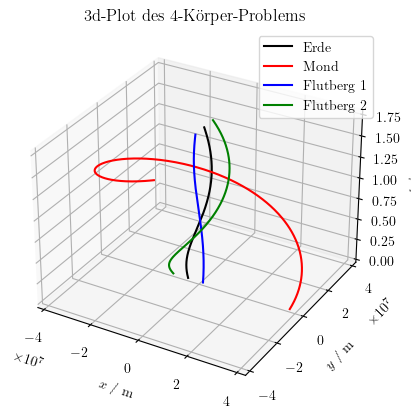

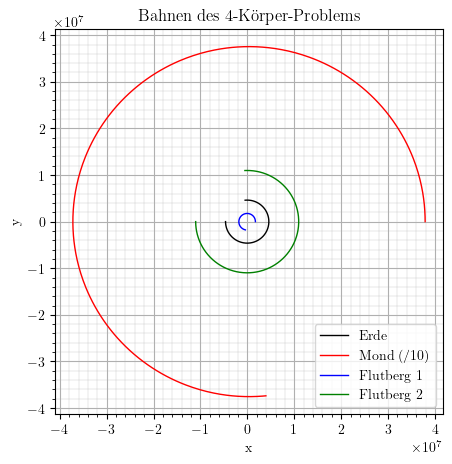

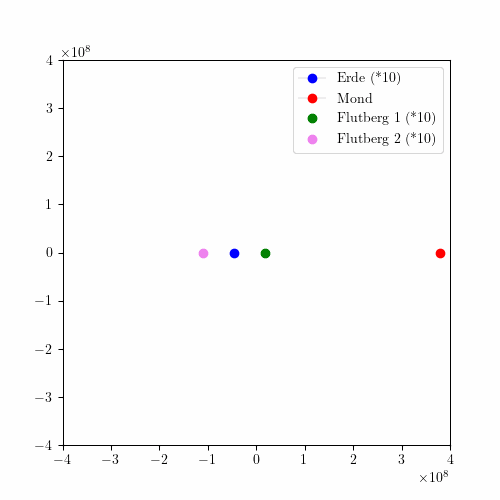

Ausgabe der per-Hand-Methode: [192021, 12422, 2348, 34142, 23455, 56463, 224619815116.04947, 2671003691970.6772, -260.2959588646813, -39339.79448240955, 268732.74115708674, -46351.59623989007]
Ausgabe der Sympy-Methode:    [192021, 12422, 2348, 34142, 23455, 56463, 224619815116.04947, 2671003691970.677, -260.2959588646814, -39339.79448240956, 268732.7411570847, -46351.59623992443]


In [16]:
# The tides' positions in cartesian coordinates
x_1, y_1, x_2, y_2 = x_E + RErde*np.cos(phi_1), y_E + RErde*np.sin(phi_1), x_E + RErde*np.cos(phi_2), y_E + RErde*np.sin(phi_2)
x_1S, y_1S, x_2S, y_2S = x_ES + RErde*np.cos(phi_1S), y_ES + RErde*np.sin(phi_1S), x_ES + RErde*np.cos(phi_2S), y_ES + RErde*np.sin(phi_2S)

# Plot the solution of the two body problem as a phase space diagram
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 12)) # Create a figure and a set of subplots
fig.suptitle("Phasenraumdiagramme des Erde-Mond-Flutberg-Systems: per-Hand und mit Sympy")

def init_phase_space(ax, a, b, title, xlabel, ylabel, color):
    ax.plot(a, b, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

init_phase_space(axes[0,0], t, x_E, "x-Position Erde", "$t$ / s", "$x_1$ / m", "blue")
init_phase_space(axes[0,1], t, x_M, "x-Position Mond", "$t$ / s", "$x_2$ / m", "red")
init_phase_space(axes[1,0], t, y_E, "y-Position Erde", "$t$ / s", "$y_1$ / m", "blue")
init_phase_space(axes[1,1], t, y_M, "y-Position Mond", "$t$ / s", "$y_2$ / m", "red")
init_phase_space(axes[2,0], x_E, y_E, "Rotation Erde", "$x_E$ / m", "$y_E$ / m", "blue")
init_phase_space(axes[2,1], x_M, y_M, "Rotation Mond", "$x_M$ / m", "$y_M$ / m", "red")
init_phase_space(axes[3,0], t, phi_1, "Winkel Flutberg 1", "$t$ / s", "$\phi_1$ / rad", "blue")
init_phase_space(axes[3,1], t, phi_2, "Winkel Flutberg 2", "$t$ / s", "$\phi_2$ / rad", "red")
init_phase_space(axes[4,0], x_1, y_1, "Rotation Flutberg 1", "$x_1$ / m", "$x_2$ / m", "blue")
init_phase_space(axes[4,1], x_2, y_2, "Rotation Flutberg 2", "$y_1$ / m", "$y_2$ / m", "red")

init_phase_space(axes[0,2], tS, x_ES, "x-Position Erde Sympy", "$t$ / s", "$x_1$ / m", "blue")
init_phase_space(axes[0,3], tS, x_MS, "x-Position Mond Sympy", "$t$ / s", "$x_2$ / m", "red")
init_phase_space(axes[1,2], tS, y_ES, "y-Position Erde Sympy", "$t$ / s", "$y_1$ / m", "blue")
init_phase_space(axes[1,3], tS, y_MS, "y-Position Mond Sympy", "$t$ / s", "$y_2$ / m", "red")
init_phase_space(axes[2,2], x_ES, y_ES, "Rotation Erde Sympy", "$x_E$ / m", "$y_E$ / m", "blue")
init_phase_space(axes[2,3], x_MS, y_MS, "Rotation Mond Sympy", "$x_M$ / m", "$y_M$ / m", "red")
init_phase_space(axes[3,2], tS, phi_1S, "Winkel Flutberg 1 Sympy", "$t$ / s", "$\phi_1$ / rad", "blue")
init_phase_space(axes[3,3], tS, phi_2S, "Winkel Flutberg 2 Sympy", "$t$ / s", "$\phi_2$ / rad", "red")
init_phase_space(axes[4,2], x_1S, y_1S, "Rotation Flutberg 1 Sympy", "$x_1$ / m", "$x_2$ / m", "blue")
init_phase_space(axes[4,3], x_2S, y_2S, "Rotation Flutberg 2 Sympy", "$y_1$ / m", "$y_2$ / m", "red")

plt.tight_layout() # Adjust the spacing between subplots
plt.show()
plt.close()

# Plot a 3d phase space diagram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("3d-Plot des 4-Körper-Problems")
ax.plot(x_E, y_E, t, 'k', label='Erde')
ax.plot(x_M/10, y_M/10, t, 'r', label='Mond')
ax.plot(x_1, y_1, t, 'b', label='Flutberg 1')
ax.plot(x_2, y_2, t, 'g', label='Flutberg 2')
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()

plt.show()
plt.close()

plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.title("Bahnen des 4-Körper-Problems")
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("x")
plt.ylabel("y")

plt.plot(x_E, y_E, 'k', linewidth=1, label='Erde')
plt.plot(x_M/10, y_M/10, 'r', linewidth=1, label='Mond (/10)')
plt.plot(x_1, y_1, 'b', linewidth=1, label='Flutberg 1')
plt.plot(x_2, y_2, 'g', linewidth=1, label='Flutberg 2')

plt.legend()
plt.show()
plt.close()

# Animation of the four body problem
if not fastExecution: # Don't render if not necessary
    fig = plt.figure(figsize=(5, 5)) # Square figure, so the circles are actually circles
    fig.suptitle("Animation des Vier-Körper-Problems")
    ax = plt.axes(xlim=(-4e8, 4e8), ylim=(-4e8, 4e8))
    earth_line, = ax.plot([], [], marker='o', lw=0.1, color='blue', label='Erde (*10)')
    moon_line, = ax.plot([], [], marker='o', lw=0.1, color='red', label='Mond')
    tide_1_line, = ax.plot([], [], marker='o', lw=0.1, color='green', label='Flutberg 1 (*10)')
    tide_2_line, = ax.plot([], [], marker='o', lw=0.1, color='violet', label='Flutberg 2 (*10)')
    ax.legend()

    def animate(i):
        earth_line.set_data([x_E[i]*10], [y_E[i]*10])
        moon_line.set_data([x_M[i]], [y_M[i]])
        tide_1_line.set_data([x_1[i]*10], [y_1[i]*10])
        tide_2_line.set_data([x_2[i]*10], [y_2[i]*10])
        return earth_line, moon_line

    anim = FuncAnimation(fig, animate, init_func=None, frames=t.shape[0], interval=30, blit=True)
    anim.save('Erde_Mond_Flutberge.gif', writer='pillow')
    plt.close()

display(Image(data=open('Erde_Mond_Flutberge.gif','rb').read(), format='png'))

# Compare the numerical output of the two methods
state = [123, 456, 789, 101112, 131415, 161718, 192021, 12422, 2348, 34142, 23455, 56463]
print(f'Ausgabe der per-Hand-Methode: {eq_motion_4body(0, state, [mErde, mMond, mOzean/2, mOzean/2])}')
print(f'Ausgabe der Sympy-Methode:    {eq_motion_4body_sympy(0, state, [mErde, mMond, mOzean/2, mOzean/2])}')

#### Überprüfung

An den Laufzeiten der beiden Zellen für die Simulation sieht man nocheinmal deutlich den Unterschied zwischen den beiden Methoden.

Wie in den Graphen unschwer zu erkennen ist, liefern die beiden Methoden die gleichen Ergebnisse.
Am numerischen Output erkennt man aber, dass es kleine Abweichungen gibt.
Auf den im Bild erkennbaren Größenordnungen sieht es gut aus, um den Unterschied zu quantifizieren wollen wir uns erneut das Baryzentrum anschauen.

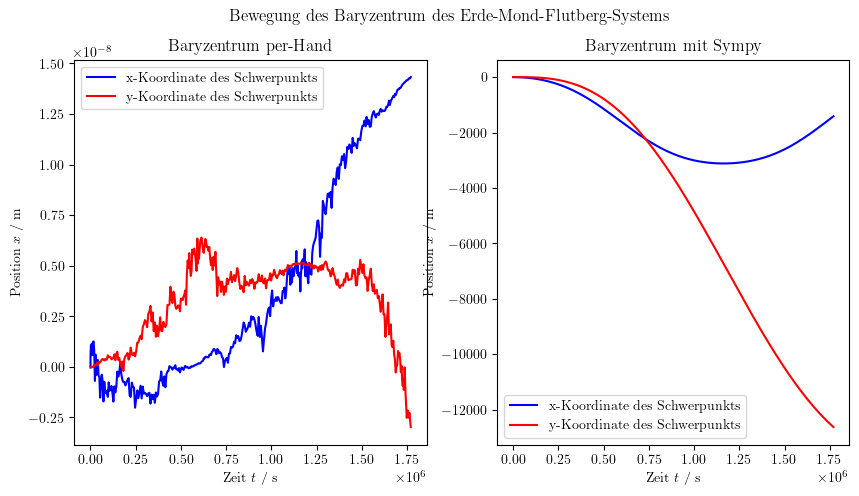

In [17]:
def center_of_mass(mass, position_x , position_y):
    '''Returns the coordinates of the center of mass of the system'''
    x = np.sum(mass * position_x, axis=1) / np.sum(mass)
    y = np.sum(mass * position_y, axis=1) / np.sum(mass)
    return [x, y]

# Plot the change of the center of mass over time
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Bewegung des Baryzentrum des Erde-Mond-Flutberg-Systems")
axes[0].plot(t, center_of_mass([mErde, mMond, mOzean/2, mOzean/2], np.array([x_E, x_M, x_1, x_2]).T, np.array([y_E, y_M, y_1, y_2]).T)[0], color='blue', label='x-Koordinate des Schwerpunkts')
axes[0].plot(t, center_of_mass([mErde, mMond, mOzean/2, mOzean/2], np.array([x_E, x_M, x_1, x_2]).T, np.array([y_E, y_M, y_1, y_2]).T)[1], color='red', label='y-Koordinate des Schwerpunkts')
axes[0].set_xlabel('Zeit $t$ / s')
axes[0].set_ylabel('Position $x$ / m')
axes[0].set_title('Baryzentrum per-Hand')
axes[0].legend()
axes[1].plot(t, center_of_mass([mErde, mMond, mOzean/2, mOzean/2], np.array([x_ES, x_MS, x_1S, x_2S]).T, np.array([y_ES, y_MS, y_1S, y_2S]).T)[0], color='blue', label='x-Koordinate des Schwerpunkts')
axes[1].plot(t, center_of_mass([mErde, mMond, mOzean/2, mOzean/2], np.array([x_ES, x_MS, x_1S, x_2S]).T, np.array([y_ES, y_MS, y_1S, y_2S]).T)[1], color='red', label='y-Koordinate des Schwerpunkts')
axes[1].set_xlabel('Zeit $t$ / s')
axes[1].set_ylabel('Position $x$ / m')
axes[1].set_title('Baryzentrum mit Sympy')
axes[1].legend()

plt.show()
plt.close()

SymPy macht deutlich mehr Fehler als die per Hand berechneten Funktionen, aus den bereits oben genannten Gründen.